# Webscraping from arXiv.org

This Jupyter Notebook was a way for me to learn more about web scraping in Python and also try our some new visualization techniques. I chose the website arxiv.org, since it has lots of info and I could work with the html behind it easily.

I decided to learn more about protoplanetary disks (namely HD 163296), a topic I wrote my Bachelor's thesis about and see whats trending :)

In [1]:
from bs4 import BeautifulSoup
from urllib.request import urlopen
import re

### The WebScraping Part

On arxiv.org the max amount of results we can get on one page is 200, and we sort them by "newest date". For each webpage we get, we store the html behind it in a soup object and append all these "soups" to a list.

In [28]:
'''
Create a Soup Object for each website we call and store them in a list called 'soups'. 
Later, we will arrange all this information into one dictionary.
'''
soups = []
queries = ['protoplanetary disk', 'protoplanetary disc', 'hd 163296']
start_points = [0, 200, 400, 600, 800, 1000]

for i in range(len(queries)):
    # I know that my queries always have a space character in them
    query = queries[i].replace(" ", "+")
    for j in range(len(start_points)):
        url = 'https://arxiv.org/search/?query={0}&searchtype=all&abstracts=show&order=-announced_date_first&size=200&start={1}'.format(query, start_points[j])
        html = urlopen(url)
        soup = BeautifulSoup(html, 'lxml')
        soups.append(soup)

Since the results we get will always contain some kind of highlighted field, like "protoplanetary disk", we need to handle things like this: `<span class="search-hit mathjax">protoplanetary disks</span>` to find the titles and abstracts correctly. So we define a function which will extract whatever is inside this class.

In [29]:
'''
the highlighted word will be seen further in abstracts and titles and we want to extract it from the corresponding tag.
an example can be seen with the word "automobiles".
'''
string = '<span class="search-hit mathjax">automobiles</span>'
def string_highlight(st):
    result = re.search('<span class="search-hit mathjax">(.*)</span>', st)
    return result.group(1)

Now we create functions which extract the title, abstract and dates for each article.

In [30]:
'''
We extract the title from the soup object, which contains only one article.
'''
def find_title(soup_object):
    tags = soup_object("p", "title is-5 mathjax")
    for tag in tags:
        # no highlighted fields
        if len(tag) == 1:
            final_title = str(tag.contents[0]).strip()
        else:
            to_title = []
            for i in range(len(tag.contents)):
                element = str(tag.contents[i]).strip()
                # check if there are highlighted fields
                if 'span class="search-hit mathjax"' in element:
                    to_title.append(string_highlight(element))
                else:
                    to_title.append(element)
            final_title = ' '.join(to_title)
    return final_title

In [31]:
'''
We extract the full abstract of the papers from the soup object, which contains only one article.
'''

def find_abstract(soup_object):
    tags = soup_object("span", {'class': 'abstract-full has-text-grey-dark mathjax'})
    for tag in tags:
        to_abstract = []
        # we can always skip the last two tags
        for i in range(len(tag.contents) - 2):
            # convert navigable string to string
            element = str(tag.contents[i]).strip()
            # check for highlighted text
            if 'span class="search-hit mathjax"' in element:
                to_abstract.append(string_highlight(element))
            else:
                to_abstract.append(element)
            # the final string would consist of substring either containing the highlight or not
            final_abstract = ' '.join(to_abstract)
    return final_abstract

In [32]:
'''
We extract the link to the pdf of the paper from the soup object, which contains only one article.
'''

def find_link(soup_object):
    tags = soup_object("p", "list-title is-inline-block")
    links = []
    for tag in tags:
        tag_string = str(tag)
        if 'pdf</a>' in tag_string:
            split = tag_string.split('=')
            for sp in split:
                if 'pdf</a>' in sp:
                    idx = sp.find('pdf</a>')
                    result = re.search('"(.*)">pdf</a>', sp)
                    links.append(result.group(1))
        else:
            links.append('No Link')
    return links[0]

In [33]:
'''
We extract the submission date of the papers from the soup object, which contains only one article.
'''
from datetime import datetime

def find_dates(soup_object):
    tags = soup_object("p", "is-size-7")
    for tag in tags:
        # convert navigable string to string
        tag_string = str(tag)
        # can't write "submitted" here because sometimes comments also have the word "submitted" in them 
        if 'riginally announced' in tag_string:
            split = tag_string.split(';')
            for sp in split:
                idx = sp.find('Submitted')
                if idx != -1:
                    idx = idx + 16
                    # append to list of dates in datetime-datetime format
                    date = datetime.strptime(sp[idx:].strip(), "%d %B, %Y")
                    # append to list of dates, which look nice
                    pretty = sp[idx:].strip()
    return date, pretty

#### Initializing the dictionary

It proves quite useful to store information in the dictionary, where the keys are the titles of the papers and the values are the corresponding abstracts, links and dates.

In [34]:
'''
We create a dictionary where a key holds the title of the papers and assign abstract, link to pdf and dates 
to the values of this key.
'''

def create_dictionary(soup_object):
    dictionary = {}
    # information about each paper is hidden in class "arxiv-result"
    papers = soup_object.find_all("li", attrs={"class": "arxiv-result"})
    for paper in papers:
        title = find_title(paper)
        abstract = find_abstract(paper)
        link = find_link(paper)
        date, pretty_date = find_dates(paper)
        # initialize entries in dictionary
        dictionary[title] = abstract, link, date, pretty_date
    return dictionary

In [35]:
'''
If we cannot find a link to the pdf, we consider the entry invalid and delete it from the dictionary.
'''
def delete_invalid(dic):
    invalid_titles = []
    for title in dic:
        if dic[title][1] == 'No Link':
            invalid_titles.append(title)
    return {title: dic[title] for title in dic if title not in invalid_titles}

In [36]:
# create a dictionary with info from all soup objects
info_dic = {}
for i in range(len(soups)):
    info_dic_temp = create_dictionary(soups[i])
    info_dic.update(info_dic_temp)
    
info_dic = delete_invalid(info_dic)

In [37]:
# based on the assumption that the two articles with the exact same name are actually the same articles 
# we delete the duplicates
uniques = list(set(key for key in info_dic.keys()))
updated_dic = {}

for title in uniques:
    updated_dic[title] = info_dic[title]

In [38]:
# to visualize the data it is useful to create lists that would store information on the dates, titles etc ...
def get_info(dic):
    tis = [key for key in dic]
    abs = [dic[key][0] for key in dic]
    lis = [dic[key][1] for key in dic]
    das = [dic[key][2] for key in dic]
    return tis, abs, lis, das
titles, abstracts, links, dates = get_info(updated_dic)

## Analysis

In this part we make a small visualization to see what words come up frequently in titles of papers. A wordcloud seems like the prettiest and easiest to understand. We can also define words and phrases we are most interested in and see how often they come up in a bar chart.

In [39]:
from dateutil.relativedelta import relativedelta

In [40]:
'''
We want to filter out our reluts according to the publishing date.
Like we would only want articles published no later than 24 months ago.
'''

def get_relevant_dates(date_list, ago = 24):
    present = datetime.now()
    past = present - relativedelta(months = ago)
    # we actually get indices of the relavant dates
    return [i for i in range(len(date_list)) if date_list[i] > past]

In [41]:
indices = get_relevant_dates(dates)
relevant_titles = [titles[i] for i in indices]
relevant_abstracts = [abstracts[i] for i in indices]

In [42]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [43]:
stopwords = ['of', 'for', 'in', 'while', 'when', 'what', 'and', 'may', 'the', 'a', 'an', 'using', 'to', 'on', 'by',
            'as', 'one', 'two', 'three', 'first', 'second', 'third', 'few', 'less', 'more', 'little', 'then', 
            'than', 'not', 'no', 'use', 'around', 'with', 'new', 'shape', 'from', 'at']

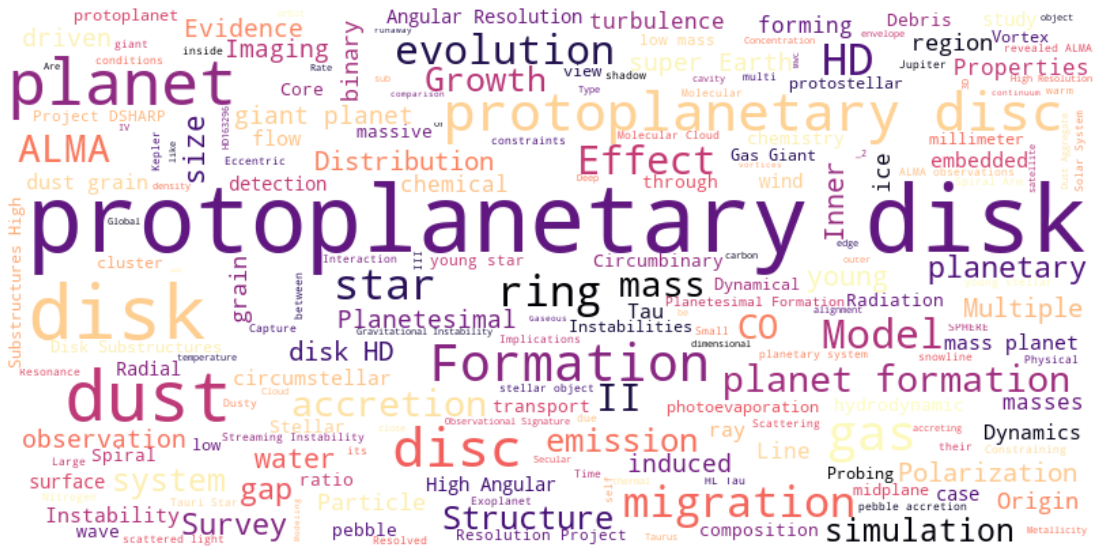

In [44]:
text_titles = ' '.join(title for title in relevant_titles)
wc_titles = WordCloud(background_color = 'white', max_font_size = 80, max_words = 200, width = 800, height = 400,
                      stopwords = stopwords, colormap = 'magma', contour_width = 2, contour_color = 'deeppink')

wc_titles.generate(text_titles)

plt.figure(figsize = [20, 10])
plt.imshow(wc_titles, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [45]:
import plotly.express as px
import plotly.graph_objects as go

**We see that words like ALMA and SPHERE are quite large in the image, much like giant planet and dust. I was personally interested in HD as well.**

In [46]:
wordcloud_phrases = ['ALMA', 'HD', 'SPHERE', 'CO', 'dust', 'giant planet']

def get_count(to_count, rel_titles):
    counts = []
    for tc in to_count:
        keys = [key for key in rel_titles if key.find(tc) != -1 or key.find(tc.lower()) != -1]
        counts.append(len(keys))
    return counts

wordcloud_phrases_counts = get_count(wordcloud_phrases, relevant_titles)

In [47]:
# to sort the bar chart in descending order
sortx = [words for _,words in sorted(zip(wordcloud_phrases, wordcloud_phrases), reverse = True)]
sorty = sorted(wordcloud_phrases_counts, reverse = True)

data = go.Bar(x = sortx, y = sorty, hoverinfo = 'text', marker_color = 'mediumvioletred',
             hovertext = ["The word '{0}' pops up {1} times".format(sortx[i], sorty[i]) for i in range(len(sortx))])
layout = go.Layout(title = go.layout.Title(
                    text = 'Most Common Words in Titles',
                    xref = 'paper',
                    x = 0.5,
                    xanchor = 'center'))
fig = go.Figure(data = data, layout = layout)
fig.show()

In [48]:
'''
If we are interested in articles containing a certain word we can pring it out here.
'''

def interesting_titles(list_titles, word):
    tils = []
    for title in list_titles:
        if title.find(word) != -1 or title.find(word.lower()) != -1:
            tils.append(title)
    return tils

### Let's see what articles contain 'HD 163296' in them and print the links to these articles.

In [49]:
words_we_want = ['HD 163296']
# interesting_titles(relevant_titles, words_we_want[-1])

In [50]:
def get_link(dic, list_titles):
    liks = []
    for title in list_titles:
        liks.append('<a href="{link}">{text}</a>'.format(text = title, link = dic[title][1]))
    return liks

In [51]:
titles_we_want = interesting_titles(relevant_titles, words_we_want[-1])
links_we_want = get_link(updated_dic, titles_we_want)

In [52]:
from IPython.core.display import display, HTML, Markdown

In [53]:
display(Markdown("**Clickable article titles containing the word '{}'**".format(words_we_want[0])))
for link in links_we_want:
    display(HTML(link))

**Clickable article titles containing the word 'HD 163296'**